## Libiraries

In [ ]:
!pip install ultralytics
!pip install -U ultralytics
!pip install easyocr
!pip install paddleocr
!pip install paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9

In [5]:
import os
import cv2
import glob
import yaml
import shutil
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch

from PIL import Image
from ultralytics import YOLO
import easyocr
# from paddleocr import PaddleOCR   # لو هتستخدم PaddleOCR بعدين

warnings.filterwarnings("ignore")


# Loading the data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudeldebase/egyptian-cars-plates")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'egyptian-cars-plates' dataset.
Path to dataset files: /kaggle/input/egyptian-cars-plates


In [ ]:
print(os.listdir(path))

['EALPR Vechicles dataset']


In [ ]:
dataset_path = os.path.join(path, "EALPR Vechicles dataset")

# مسار الصور والليبلز
images_path = os.path.join(dataset_path, "Vehicles")
labels_path = os.path.join(dataset_path, "Vehicles Labeling")

# الملفات
image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

print("Images:", len(image_files))
print("Labels:", len(label_files))

Images: 2087
Labels: 2088


In [ ]:
print(f"Total images: {len(image_files)}")
print(f"Total labels: {len(label_files)}")

# show some samples
print("Sample images:", image_files[:5])
print("Sample labels:", label_files[:5])

# make sure each image has a corresponding label
for i in range(5):  # check first 5 files
    img_name = os.path.splitext(image_files[i])[0]
    lbl_name = os.path.splitext(label_files[i])[0]
    print(f"{img_name} <--> {lbl_name}")


Total images: 2087
Total labels: 2088
Sample images: ['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']
Sample labels: ['0001.txt', '0002.txt', '0003.txt', '0004.txt', '0005.txt']
0001 <--> 0001
0002 <--> 0002
0003 <--> 0003
0004 <--> 0004
0005 <--> 0005


# Functions for labels

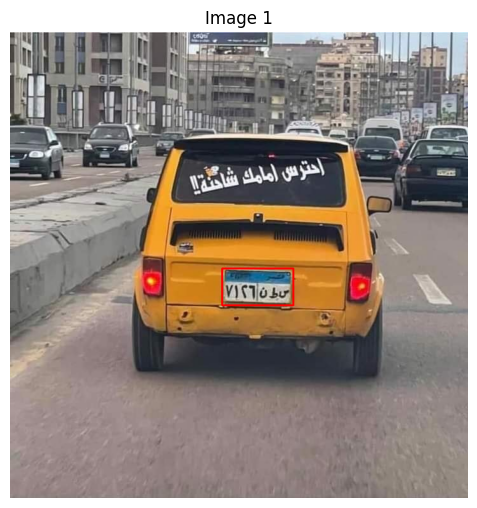

In [ ]:
# Function to load bounding boxes from the label file
def load_bounding_boxes(label_file):
    bounding_boxes = []
    with open(label_file, 'r') as file:
        for line in file.readlines():
            values = line.strip().split()
            class_id = int(values[0])  # Class ID (optional if needed)
            x_center = float(values[1])
            y_center = float(values[2])
            width = float(values[3])
            height = float(values[4])
            bounding_boxes.append([x_center, y_center, width, height])
    return bounding_boxes

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image, bounding_boxes):
    h, w = image.shape[:2]
    for bbox in bounding_boxes:
        x_center, y_center, box_width, box_height = bbox
        # Convert YOLO format to corner coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        # Draw the rectangle on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return image

# Function to display image with bounding boxes
def plot_images_with_boxes(image_files, label_files):
    n = len(image_files)
    cols = 3  # عدد الأعمدة في العرض
    rows = (n + cols - 1) // cols  # نحسب عدد الصفوف تلقائي

    plt.figure(figsize=(15, 5 * rows))

    for i, (image_file, label_file) in enumerate(zip(image_files, label_files)):
        # Load the image
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load bounding boxes
        bounding_boxes = load_bounding_boxes(label_file)

        # Draw bounding boxes
        image_with_boxes = draw_bounding_boxes(image, bounding_boxes)

        # Subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_with_boxes)
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()


# List all images and labels
image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

# Plot a sample image with bounding boxes
sample_index = 0  # Change this to view a different sample
sample_image_file = os.path.join(images_path, image_files[sample_index])
sample_label_file = os.path.join(labels_path, label_files[sample_index])

plot_images_with_boxes([sample_image_file], [sample_label_file])

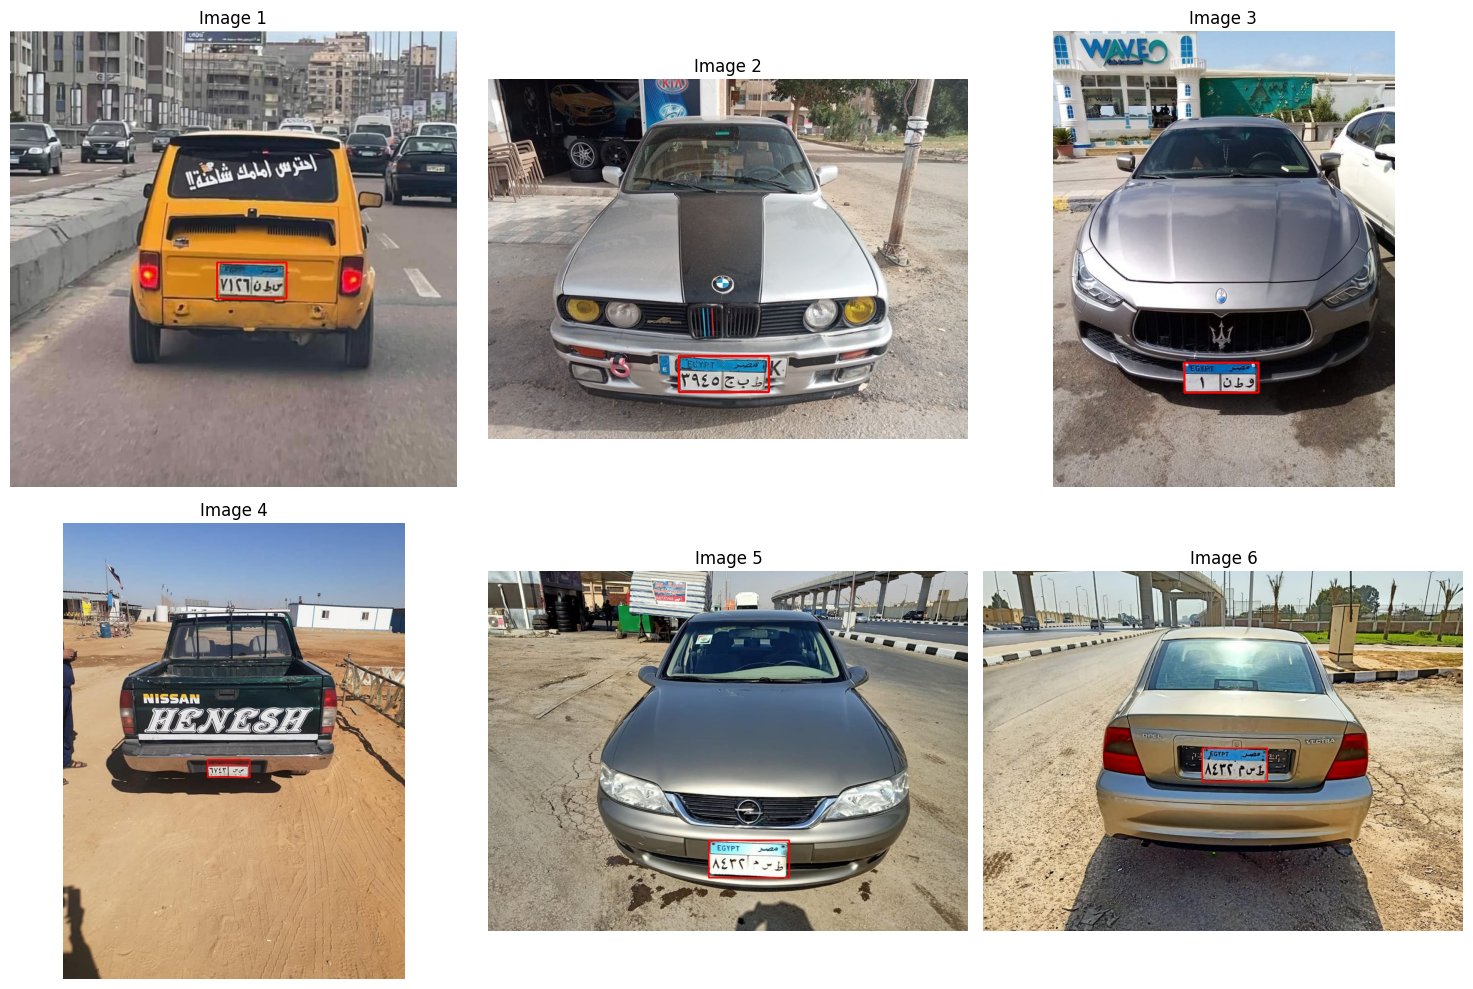

In [ ]:
# Plot multiple sample images with bounding boxes
sample_images = [os.path.join(images_path, f) for f in image_files[:6]]
sample_labels = [os.path.join(labels_path, f) for f in label_files[:6]]

plot_images_with_boxes(sample_images, sample_labels)


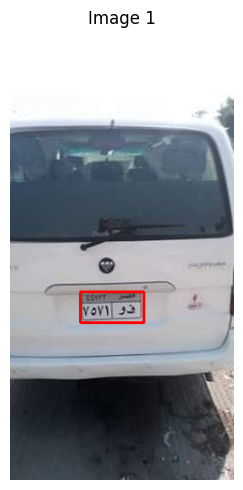

In [ ]:
sample_image_file = os.path.join(images_path, image_files[8])
sample_label_file = os.path.join(labels_path, label_files[8])

plot_images_with_boxes([sample_image_file], [sample_label_file])

# Preprocess the images

In [ ]:
# Prepare dataset function
def prepare_dataset(images_path, labels_path, output_path, target_size=(640, 640), split_ratio=0.8):
    """
    Resize images and split dataset into train/val with labels.
    """

    # makwe sure folders exist
    for sub in ["train/images", "train/labels", "val/images", "val/labels"]:
        os.makedirs(os.path.join(output_path, sub), exist_ok=True)

    # get all images from the directory
    image_files = sorted(os.listdir(images_path))
    random.shuffle(image_files)  # Shuffle before splitting

    # Split train/val
    split_index = int(len(image_files) * split_ratio)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    def process_and_copy(files, split_name):
        for file in files:
            # image path
            img_path = os.path.join(images_path, file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"[SKIP] Couldn't read image: {img_path}")
                continue  # Skip if image not read

            # Resize
            img_resized = cv2.resize(img, target_size)

            # Save resized image
            save_img_path = os.path.join(output_path, f"{split_name}/images", file)
            cv2.imwrite(save_img_path, img_resized)

            # Label filename (نفس اسم الصورة لكن .txt)
            label_file = os.path.splitext(file)[0] + ".txt"
            src_label_path = os.path.join(labels_path, label_file)
            dst_label_path = os.path.join(output_path, f"{split_name}/labels", label_file)

            # لو فيه label انسخه
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)
            else:
                print(f"[WARNING] No label for image: {file}")

    # Train + Val
    process_and_copy(train_files, "train")
    process_and_copy(val_files, "val")

    print(f"✅ Dataset prepared at: {output_path}")
    print(f"Train samples: {len(train_files)} | Val samples: {len(val_files)}")


In [ ]:
prepare_dataset(images_path, labels_path, output_path="dataset", target_size=(640, 640), split_ratio=0.8)

✅ Dataset prepared at: dataset
Train samples: 1669 | Val samples: 418


# Check the dataset

In [ ]:
def check_dataset(path):
    for split in ["train", "val"]:
        img_dir = os.path.join(path, split, "images")
        lbl_dir = os.path.join(path, split, "labels")

        imgs = sorted(os.listdir(img_dir))
        lbls = sorted(os.listdir(lbl_dir))

        print(f"\n{split.upper()}:")
        print(f"Images: {len(imgs)} | Labels: {len(lbls)}")

        # check if every image has a label
        img_names = [os.path.splitext(f)[0] for f in imgs]
        lbl_names = [os.path.splitext(f)[0] for f in lbls]
        missing_labels = set(img_names) - set(lbl_names)
        missing_images = set(lbl_names) - set(img_names)

        if missing_labels:
            print(f"⚠️ Missing labels for: {list(missing_labels)[:5]}")
        if missing_images:
            print(f"⚠️ Missing images for: {list(missing_images)[:5]}")

check_dataset("dataset")



TRAIN:
Images: 1669 | Labels: 1669

VAL:
Images: 418 | Labels: 418


# Training the model

In [ ]:
import torch

model = YOLO("yolov8n.pt")  # Use nano model for faster training

# Train the model
model.train(
    data='data.yaml',
    epochs=20,
    batch=32,
    imgsz=640,
    cache=True,
    device=0,
    name='yolov8n_car_plate',
    plots=False
)


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_car_plate, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.0, pretr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787b2bfef6b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Evaluate
model.val()


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2297.6±649.8 MB/s, size: 147.9 KB)
val: Scanning /content/dataset/val/labels.cache... 418 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 418/418 825.4Kit/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.5GB RAM): 100% ━━━━━━━━━━━━ 418/418 287.8it/s 1.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 2.8it/s 5.0s
                   all        418        433      0.995      0.988      0.995      0.907
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 1.9ms postprocess per image


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7879b777f680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing



image 1/1 /content/test2.jpg: 512x640 1 plate, 116.6ms
Speed: 4.6ms preprocess, 116.6ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)
Results saved to /content/runs/detect/yolov8n_car_plate3


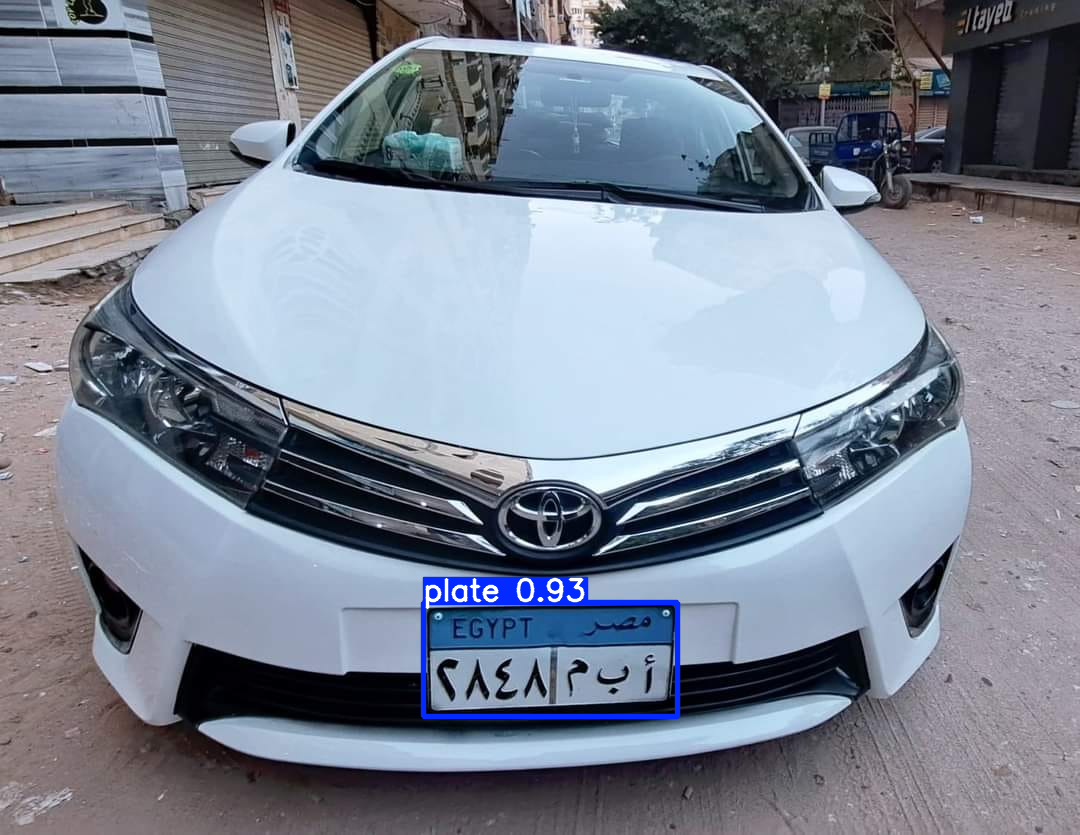

In [ ]:
results = model.predict("/content/test2.jpg", save=True)
results[0].show()


image 1/1 /content/test2.jpg: 512x640 1 plate, 9.3ms
Speed: 3.7ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)
Results saved to /content/runs/detect/predict


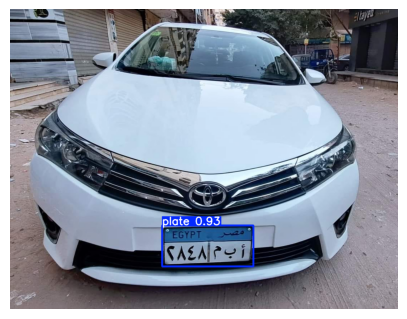

In [ ]:
import cv2
# Load the best model
best_model = YOLO("/content/runs/detect/yolov8n_car_plate/weights/best.pt")

# Test image
test_image = "/content/test2.jpg"

# Predict
results = best_model.predict(test_image, save=True)

# ناخد الصورة المرسوم عليها من YOLO
annotated_img = results[0].plot()
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(annotated_img)
plt.axis("off")
plt.show()


# Trying Easyocr


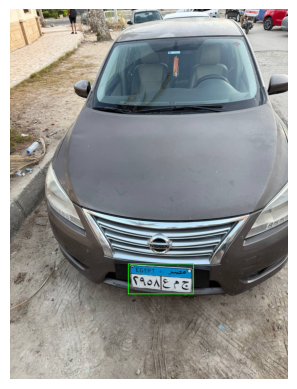

EasyOCR result: EGYPT | م74 | جم ٢٩٥٨١٤


In [ ]:
# Function 1: Detect plate using YOLO model
def detect_plate(model_path, image_path):
    """
    Detect license plate in the image using YOLO.
    Returns cropped plate image(s) and the annotated image.
    """
    model = YOLO(model_path)
    results = model.predict(image_path, verbose=False)

    # Read image
    img = cv2.imread(image_path)

    # Extract boxes
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    cropped_plates = []
    for box in boxes:
        x1, y1, x2, y2 = box
        plate_crop = img[y1:y2, x1:x2]
        cropped_plates.append(plate_crop)
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return cropped_plates, img


# Function 2: Recognize text using EasyOCR
def recognize_easyocr(plate_img):
    """
    Recognize plate text using EasyOCR.
    """
    os.environ["FLAGS_use_mkldnn"] = "0"
    reader = easyocr.Reader(['ar', 'en'], gpu=True)

    # Preprocessing
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    results = reader.readtext(thresh)
    texts = [res[1] for res in results]
    return " | ".join(texts)


# Main pipeline
def main():
    image_path = "Nisan_3.jpg"   # replace with your image
    model_path = "best.pt"       # your trained YOLO model

    # Step 1: detect plate
    plates, annotated_img = detect_plate(model_path, image_path)

    # Show annotated image (original with rectangle)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Step 2: OCR on first detected plate
    if plates:
        text_easy = recognize_easyocr(plates[0])
        print("EasyOCR result:", text_easy)
    else:
        print("No plate detected!")


if __name__ == "__main__":
    main()

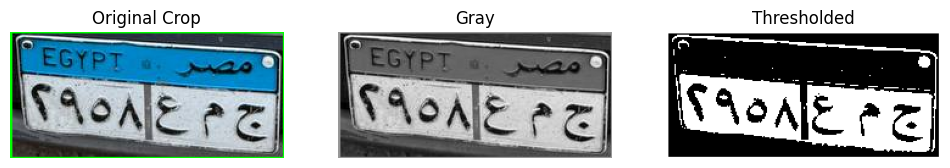

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


EasyOCR result: ٢٩٥٨٤ | ج


Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv3_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv3_mobile_det`.
Creating model: ('arabic_PP-OCRv3_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/arabic_PP-OCRv3_mobile_rec`.
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_or

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

Creating model: ('en_PP-OCRv5_mobile_rec', None)
Using official model (en_PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in `/root/.paddlex/official_models/en_PP-OCRv5_mobile_rec`.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/7.77M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

PaddleOCR Arabic: n | a | o | t | o | e | e | e | e | e | e | e | i | e | e
PaddleOCR English: n | a | o | t | o | e | e | e | e | e | e | e | i | e | e


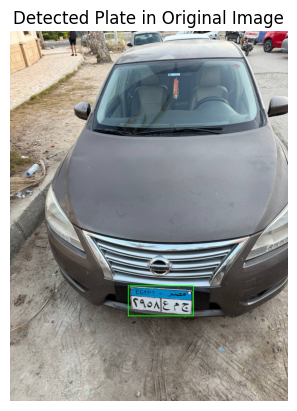

In [15]:
import cv2
import easyocr
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR

# YOLO model
model = YOLO('best.pt')

# الصورة الأصلية
image_path = "/content/Nisan_3.jpg"
results = model.predict(image_path, save=False, verbose=False)

# اقرأ الصورة
img = cv2.imread(image_path)

# هخزن الكروبس اللي طلعت
cropped_plates = []

# استخراج البوكسات
boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
for box in boxes:
    x1, y1, x2, y2 = box
    plate_crop = img[y1:y2, x1:x2]
    cropped_plates.append(plate_crop)

    # ارسم مستطيل حوالين اللوحة
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# لو لقى لوحة واحدة على الأقل
if cropped_plates:
    plate_img = cropped_plates[0]

    # عرض الصورة المقصوصة قبل المعالجة
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Crop")
    plt.axis("off")

    # Preprocessing 1: Grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    plt.subplot(1,3,2)
    plt.imshow(gray, cmap='gray')
    plt.title("Gray")
    plt.axis("off")

    # Preprocessing 2: Threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.subplot(1,3,3)
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded")
    plt.axis("off")

    plt.show()

    # ========================= OCR =========================

    # OCR بالـ EasyOCR
    os.environ["FLAGS_use_mkldnn"] = "0"
    reader = easyocr.Reader(['ar', 'en'], gpu=True)
    results_easy = reader.readtext(thresh)
    texts_easy = [res[1] for res in results_easy]
    print("EasyOCR result:", " | ".join(texts_easy))

    # OCR باستخدام PaddleOCR (عربي + إنجليزي)
    # OCR بالعربي
    ocr_ar = PaddleOCR(use_angle_cls=True, lang='ar')
    result_ar = ocr_ar.ocr(plate_img)

    # OCR بالإنجليزي
    ocr_en = PaddleOCR(use_angle_cls=True, lang='en')
    result_en = ocr_en.ocr(plate_img)

    # استخراج النصوص
    texts_ar = [line[1][0] for line in result_ar[0]] if result_ar[0] else []
    texts_en = [line[1][0] for line in result_en[0]] if result_en[0] else []

    print("PaddleOCR Arabic:", " | ".join(texts_ar))
    print("PaddleOCR English:", " | ".join(texts_en))


# عرض الصورة الكاملة بالبوكس
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detected Plate in Original Image")
plt.axis("off")
plt.show()


# Saving the best model

In [ ]:
from google.colab import files
files.download("runs/detect/yolov8n_car_plate/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>